In [1]:
EXPERIMENT = '02-01'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearnex import patch_sklearn
patch_sklearn()

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [4]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [5]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [6]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [7]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [8]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [9]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [10]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [11]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [12]:
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.9, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
X_test.drop(columns=amenity_onehot_features, inplace=True)

# Cross validation

## Preparation

In [13]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [14]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [15]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [16]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [17]:
train.set_index('id', inplace=True)

## Training models

In [18]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    with timer('Training', logger):
        estimator = LGBMRegressor(n_estimators=300,
                                  random_state=SEED,
                                  n_jobs=-1,
                                  learning_rate=0.1,
                                  importance_type='gain')
        estimator.fit(X_train, y_train, categorical_feature=discrete_features)
    
    # 予測結果を保存する
    with timer('Prediction', logger):
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        pred_test = pd.DataFrame(data=estimator.predict(X_test.drop(columns=['id'])), columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump(estimator, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


## Evaluation

In [19]:
rmse = partial(mse, squared=False)

In [20]:
metrics = defaultdict(list)

### Training set

In [21]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-03 23:07:23,714 - __main__ - INFO - CV fold 1 training loss=78.4179721
2021-08-03 23:07:23,742 - __main__ - INFO - CV fold 2 training loss=77.7384091
2021-08-03 23:07:23,764 - __main__ - INFO - CV fold 3 training loss=76.9493879
2021-08-03 23:07:23,785 - __main__ - INFO - CV fold 4 training loss=77.6680097
2021-08-03 23:07:23,810 - __main__ - INFO - CV fold 5 training loss=75.6911080
2021-08-03 23:07:23,811 - __main__ - INFO - CV training loss: average=77.2929774, std=0.9261437


In [22]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [23]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-03 23:07:24,037 - __main__ - INFO - Training loss: 96.5764223


### Validation set

In [24]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-03 23:07:24,069 - __main__ - INFO - CV fold 1 validation loss=104.0918695
2021-08-03 23:07:24,083 - __main__ - INFO - CV fold 2 validation loss=107.9736399
2021-08-03 23:07:24,099 - __main__ - INFO - CV fold 3 validation loss=109.4467508
2021-08-03 23:07:24,137 - __main__ - INFO - CV fold 4 validation loss=108.4675739
2021-08-03 23:07:24,151 - __main__ - INFO - CV fold 5 validation loss=112.3191648
2021-08-03 23:07:24,153 - __main__ - INFO - CV validation loss: average=108.4597998, std=2.6526966


In [25]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [26]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-03 23:07:24,359 - __main__ - INFO - Validation loss: 199.4999589


In [27]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


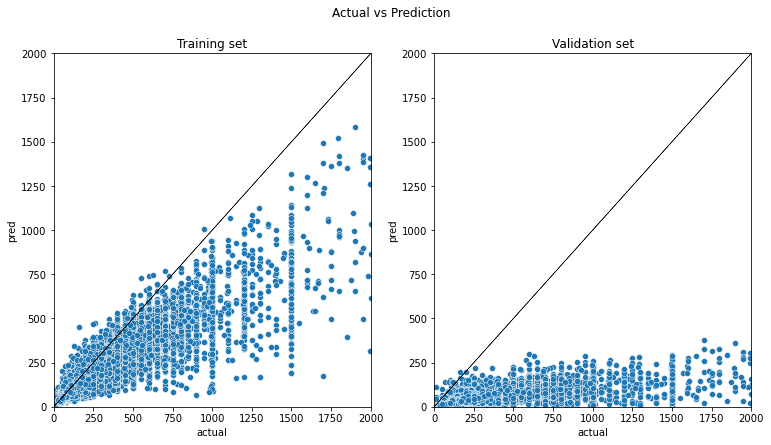

In [28]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

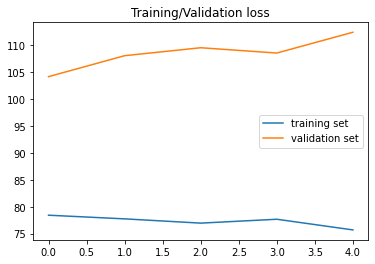

In [29]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [30]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [31]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [32]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

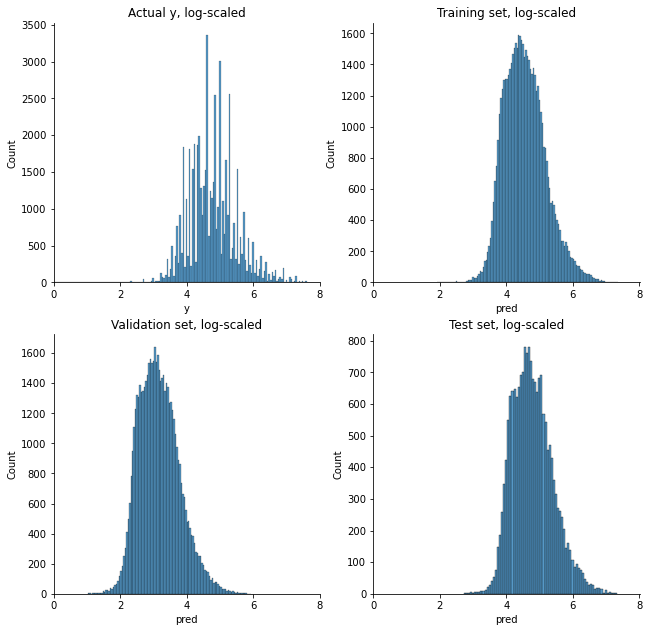

In [33]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [34]:
logger.debug('Complete({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Feature importance

In [35]:
pd.options.display.float_format = '{:.5f}'.format

In [36]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

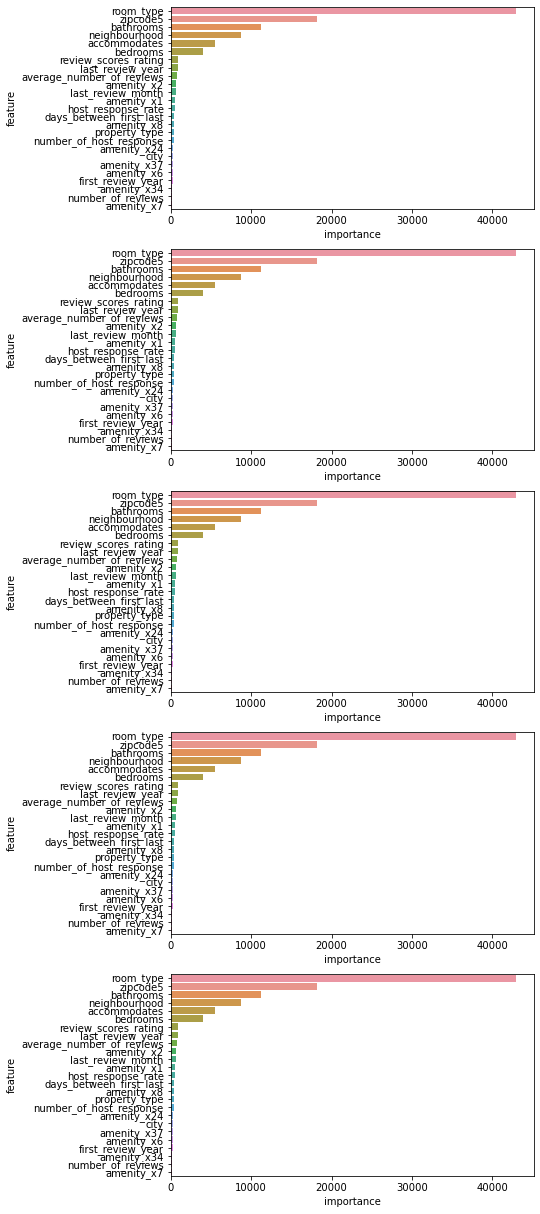

In [37]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model.feature_importances_, columns=['importance'])
    imp_df['feature'] = model.feature_name_
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance.png'))

# Error

In [38]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [39]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

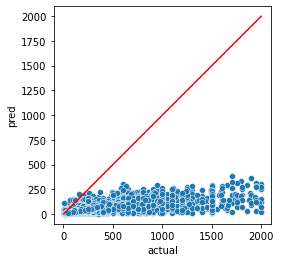

In [40]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

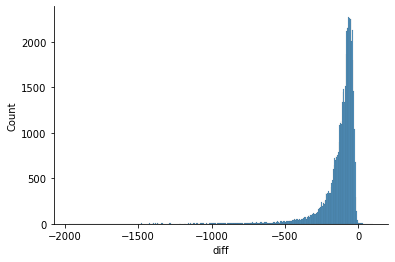

In [41]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [42]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [43]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

                                             |                                             | [  0%]   00:00 ->…

Report C:\Users\nndropout\aiquest2021-assesment\experiments\02-01\sweetviz_error_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Wall time: 39.1 s


In [44]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [45]:
diff_df.sort_values('diff').head(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month,amenity_x1,amenity_x2,amenity_x3,amenity_x4,amenity_x5,amenity_x6,amenity_x7,amenity_x8,amenity_x9,amenity_x10,amenity_x11,amenity_x12,amenity_x13,amenity_x14,amenity_x15,amenity_x16,amenity_x17,amenity_x18,amenity_x19,amenity_x20,amenity_x21,amenity_x22,amenity_x23,amenity_x24,amenity_x25,amenity_x26,amenity_x27,amenity_x28,amenity_x29,amenity_x30,amenity_x31,amenity_x32,amenity_x33,amenity_x34,amenity_x35,amenity_x36,amenity_x37,amenity_x38,diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40313,2,1.00000,0,1.00000,1.00000,1,3,0,1,1,100.00000,0,37.78704,-122.49322,484,0,1,NaN,0,NaN,NaN,0.00000,NaN,0,230,0,0,NaN,NaN,2015.00000,2.00000,NaN,NaN,-0.98598,-0.50971,-0.14381,0.88011,0.47020,-1.66575,0.36894,0.86084,-1.32572,0.84898,0.19969,1.20966,1.38035,-0.47130,-1.38793,1.03756,0.38361,-0.72492,0.50182,0.91009,0.26756,0.71786,-0.58625,-2.28689,0.68518,0.12817,0.06612,0.22450,0.39649,0.34178,1.44407,0.16081,2.11919,0.06188,-2.36979,0.55196,0.27265,0.06530,-1973.51521
47605,6,1.00000,0,1.00000,2.00000,1,1,0,1,1,NaN,0,38.94702,-77.06670,0,0,0,NaN,1,NaN,NaN,NaN,NaN,1,173,0,1,NaN,NaN,2016.00000,10.00000,NaN,NaN,0.38091,-1.19078,0.16443,-0.29578,0.04778,0.15948,-0.39985,0.80960,-0.82892,0.63717,0.37031,-0.34802,-0.10257,-1.76990,1.18775,0.17927,-1.10240,2.94742,-0.23480,-0.09212,1.58036,-0.67200,-0.36530,2.40120,0.46229,-1.05436,0.11241,-1.21491,0.59251,0.00917,-1.97233,-0.37667,0.50707,1.40186,0.56615,-0.03328,-0.06649,-0.72734,-1927.75761
39193,2,1.00000,0,1.00000,2.00000,0,1,0,1,0,NaN,0,38.90100,-77.05266,157,0,0,NaN,1,NaN,NaN,NaN,NaN,1,190,0,1,NaN,NaN,2015.00000,7.00000,NaN,NaN,-0.56563,-1.24281,0.07309,0.63217,-1.41470,1.07756,1.03968,0.31754,-0.35316,-1.11792,2.08714,-0.02670,-0.49698,0.35851,-0.51328,-0.43282,1.99117,-0.02885,-2.02410,0.71287,0.41960,-1.50930,-0.59762,-0.55203,1.76152,-0.43510,0.79823,-0.80358,1.00305,-0.59577,-1.45517,0.39382,-0.06063,1.67763,-0.09686,0.08749,-0.24695,-0.68558,-1916.27131
6546,7,3.50000,0,4.00000,4.00000,1,2,1,1,0,80.00000,1,40.73300,-73.99413,53,1,2,80.00000,1,1.00000,1.00000,80.00000,80.00000,2,76,0,0,2017.00000,9.00000,2017.00000,8.00000,2017.00000,9.00000,0.86847,-0.51094,0.22896,0.16245,0.07859,-2.21560,0.07953,-1.25213,-0.96756,-0.68603,0.78762,2.10228,-1.70732,-0.50109,-0.44391,-0.61956,0.19648,0.07444,1.59189,-0.83342,0.71830,0.08947,2.25701,0.13940,0.11526,0.46105,0.65242,0.63776,-1.53610,2.12993,0.10534,0.07536,-0.51511,0.72090,-0.82193,-1.09488,-1.74955,-0.63027,-1875.81198
28682,16,8.00000,0,7.00000,16.00000,2,0,1,1,0,73.00000,1,33.99476,-117.99379,0,0,1,NaN,1,NaN,NaN,0.00000,NaN,0,126,0,0,NaN,NaN,2016.00000,8.00000,NaN,NaN,1.21917,-0.34786,-0.46218,-0.13039,-0.31217,-0.65839,0.67999,-0.06798,-0.40348,1.58463,-0.87846,-0.26816,-1.85818,0.55555,0.71951,0.67072,-1.92523,-2.30622,-0.78387,-0.85216,-0.37737,0.27616,2.52349,-0.82094,-0.95008,-0.81766,0.56398,-1.36653,0.24233,-1.49768,0.80736,0.34635,-0.00314,-0.50468,0.30669,-1.45644,3.12369,1.23249,-1870.54189
11816,6,2.50000,0,3.00000,3.00000,0,1,0,1,1,NaN,1,38.90500,-76.98602,41,0,1,NaN,1,NaN,NaN,NaN,NaN,1,43,0,1,NaN,NaN,2016.00000,6.00000,NaN,NaN,0.61314,-0.64827,0.24834,0.07329,-0.44121,-2.18034,-0.37745,-1.60516,-0.48653,0.44668,-1.19024,0.79977,-0.83855,0.86798,-0.69834,0.30615,-0.29937,-0.45196,0.47461,-0.14383,0.60586,0.17587,3.02665,2.82487,-0.67783,-0.95400,-1.49653,0.85814,1.72250,2.45763,-1.10468,0.17067,-0.48943,-0.17458,-0.67206,-1.98849,1.54953,0.76560,-1843.91178
34846,7,

In [46]:
diff_df.sort_values('diff').tail(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month,amenity_x1,amenity_x2,amenity_x3,amenity_x4,amenity_x5,amenity_x6,amenity_x7,amenity_x8,amenity_x9,amenity_x10,amenity_x11,amenity_x12,amenity_x13,amenity_x14,amenity_x15,amenity_x16,amenity_x17,amenity_x18,amenity_x19,amenity_x20,amenity_x21,amenity_x22,amenity_x23,amenity_x24,amenity_x25,amenity_x26,amenity_x27,amenity_x28,amenity_x29,amenity_x30,amenity_x31,amenity_x32,amenity_x33,amenity_x34,amenity_x35,amenity_x36,amenity_x37,amenity_x38,diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20321,3,1.00000,0,1.00000,1.00000,0,1,0,1,0,NaN,1,38.92485,-77.00110,343,0,5,NaN,1,NaN,NaN,NaN,NaN,1,43,0,0,NaN,NaN,2017.00000,1.00000,NaN,NaN,0.31548,0.92302,0.03468,-1.25653,0.56651,-0.99073,-1.05204,-1.29461,-0.16349,-0.28487,-0.33579,0.21982,-0.99713,0.47695,1.55531,-1.94888,-0.55405,0.64415,0.81258,-0.33493,1.04381,-0.13310,2.56066,2.56207,0.16825,-1.91319,-1.83030,1.42912,-1.29386,-1.18524,-0.28411,0.33439,0.24935,-0.34975,0.19973,-0.43377,1.50945,1.15390,0.09262
7223,2,1.00000,0,1.00000,1.00000,0,2,0,1,1,NaN,0,40.69974,-73.91935,2,0,0,NaN,0,NaN,NaN,NaN,NaN,2,155,0,0,NaN,NaN,2016.00000,3.00000,NaN,NaN,-1.56574,0.47943,0.41331,-0.64226,-0.70949,-0.69637,0.03704,0.12430,0.95436,0.32060,-0.06994,-1.47390,-0.01494,-0.15144,-0.20460,0.05859,2.49555,-0.70679,-0.40011,1.12069,-0.61474,-0.55189,0.10590,1.54268,-0.13568,-0.57223,-0.63952,-0.37559,-0.73702,0.48434,1.34613,1.54944,1.55170,0.00018,-2.00305,0.60998,0.11968,-0.12227,1.64721
17460,1,1.00000,3,1.00000,1.00000,0,2,0,1,0,NaN,1,40.60847,-73.99682,139,0,1,NaN,2,NaN,NaN,NaN,NaN,2,387,0,0,NaN,NaN,2017.00000,5.00000,NaN,NaN,0.00787,0.95634,0.21555,-1.05109,-0.95240,-0.57017,-0.63371,-0.94557,-0.12204,-0.28183,-1.38029,1.06730,0.81741,-1.61232,0.37440,1.21875,1.50278,-0.46884,-0.77572,-0.81797,0.31293,-0.51102,0.02411,0.42601,0.43930,-0.15754,-0.26707,-0.05546,-0.61588,-0.47424,-0.32226,0.10982,-0.42422,0.05587,0.02514,-0.88276,3.24380,1.56747,2.12624
45680,1,1.00000,0,1.00000,1.00000,0,5,1,1,1,100.00000,1,42.31378,-71.05516,61,1,5,100.00000,1,1.00000,1.00000,100.00000,100.00000,4,92,1,0,2017.00000,8.00000,2012.00000,8.00000,2017.00000,8.00000,-2.00679,0.32888,0.55461,-0.44651,0.82402,-0.77037,-0.06804,1.21461,-1.37018,0.24954,0.82123,1.04775,1.94120,-0.17021,0.00203,0.85856,-0.16627,-0.34560,0.12297,0.26171,0.30565,-0.41668,0.40214,0.88585,0.58139,-0.40532,0.24188,-0.86718,0.24196,-0.32076,-0.39926,-1.41082,-1.48611,0.12347,1.65415,-0.30683,-0.32170,0.02695,2.82395
49641,1,1.00000,0,1.00000,1.00000,0,2,0,1,0,0.00000,0,40.63321,-73.93926,63,0,1,NaN,0,NaN,NaN,0.00000,NaN,2,199,0,0,NaN,NaN,2013.00000,12.00000,NaN,NaN,-0.29566,0.25926,-1.70589,1.06176,1.93485,0.41895,0.04316,1.26400,0.74240,0.29075,0.78375,2.49300,-1.74160,0.95880,1.05761,0.61854,0.60377,1.73576,-1.46871,1.32850,1.42497,-0.34798,-1.54371,-1.07328,1.10265,0.91683,1.63375,-1.51981,0.61438,-0.04373,-2.02471,0.05154,-0.38903,0.18871,0.25530,0.03742,-0.45474,-0.22687,3.36605
20773,2,1.00000,0,1.00000,1.00000,0,1,0,1,0,100.00000,0,38.91184,-77.03602,68,18,0,99.00000,0,50.00000,0.36000,1800.00000,36.00000,1,49,0,0,2017.00000,3.00000,2015.00000,5.00000,2017.00000,5.00000,0.77509,-0.70440,-0.47862,0.15923,0.23100,0.92776,-0.15411,-0.09605,1.21792,-1.61157,-0.64270,-0.96309,-1.22722,-0.11647,-0.46446,-2.20143,-0.55356,-1.05856,1.35622,0.18391,-1.63935,-2.06540,-0.50345,0.24001,-0.06721,3.17473,-0.69180,-1.72746,1.52825,0.16297,0.83403,-1.43608,0.51040,-0.03106,-0.18255,-0.28213,-1.60620,0

In [47]:
diff_df.corr()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month,amenity_x1,amenity_x2,amenity_x3,amenity_x4,amenity_x5,amenity_x6,amenity_x7,amenity_x8,amenity_x9,amenity_x10,amenity_x11,amenity_x12,amenity_x13,amenity_x14,amenity_x15,amenity_x16,amenity_x17,amenity_x18,amenity_x19,amenity_x20,amenity_x21,amenity_x22,amenity_x23,amenity_x24,amenity_x25,amenity_x26,amenity_x27,amenity_x28,amenity_x29,amenity_x30,amenity_x31,amenity_x32,amenity_x33,amenity_x34,amenity_x35,amenity_x36,amenity_x37,amenity_x38,diff
accommodates,1.00000,0.50228,-0.08076,0.70851,0.80665,0.08614,-0.03374,0.18138,0.00384,0.06027,0.04945,0.05407,-0.07940,-0.08637,0.03845,0.04232,0.05381,-0.01782,0.38343,0.01715,-0.05569,0.00949,-0.01717,-0.05666,0.01619,0.00236,0.09432,0.00803,-0.00880,0.01172,-0.00375,0.07607,-0.07254,0.32613,-0.22656,0.20457,-0.10759,-0.00809,-0.05687,0.07716,-0.04722,-0.08642,0.02136,0.04140,-0.04151,-0.07542,-0.02078,0.02978,-0.04894,-0.08156,-0.06784,0.05432,0.02015,0.00074,-0.03073,0.04875,0.03728,0.02142,0.02310,0.01081,0.02520,-0.05594,0.05070,-0.01189,0.00525,-0.04034,-0.01938,-0.00067,-0.00194,0.09633,0.04063,-0.47897
bathrooms,0.50228,1.00000,-0.04213,0.58637,0.52485,0.00676,-0.08512,0.05268,0.00337,0.01460,0.00832,0.00227,-0.13543,-0.13205,0.04363,-0.04026,0.08669,0.00670,0.14528,-0.01355,-0.00016,-0.05742,0.01634,-0.11170,0.03302,0.00054,0.09641,-0.00405,-0.00779,0.00421,-0.00931,-0.01251,-0.07239,0.19000,-0.19280,0.01686,0.04469,0.04636,-0.05191,0.10045,-0.05508,-0.03281,-0.02070,0.06291,0.00523,-0.02622,-0.02429,-0.03797,-0.02364,-0.03043,-0.02077,0.06198,0.02433,-0.01993,-0.07117,0.04436,0.04287,0.01111,0.08646,0.03325,0.02105,-0.08169,0.00970,0.01000,0.01974,-0.02602,-0.04355,0.00068,0.00586,0.05893,0.03825,-0.41934
bed_type,-0.08076,-0.04213,1.00000,-0.05730,-0.06937,-0.01374,-0.00455,-0.03315,0.00240,-0.00789,-0.00663,-0.02723,-0.00474,-0.00500,0.01471,0.00200,0.01022,-0.00117,0.03653,0.02239,0.00321,0.01340,-0.01467,-0.00421,0.01086,0.00478,-0.01255,-0.04064,0.01269,-0.02198,0.00009,-0.03797,0.00604,-0.05462,0.01483,-0.03597,0.02053,0.03427,0.01641,0.02032,0.03345,0.04186,0.00394,-0.00378,0.01511,0.02272,-0.00916,0.00063,0.01716,0.00149,-0.00908,0.00248,-0.00736,0.00815,-0.00521,0.00285,0.01087,-0.01981,-0.00000,-0.01887,-0.00761,0.01659,0.00663,0.00709,-0.00858,0.00507,0.00575,0.00724,-0.00412,0.00803,0.00910,0.04793
bedrooms,0.70851,0.58637,-0.05730,1.00000,0.70823,0.03397,-0.00920,0.10670,0.00376,0.02643,0.02195,-0.00085,-0.05750,-0.07403,0.04969,-0.03376,0.01065,0.01000,0.19843,0.01198,-0.02189,-0.05325,-0.01011,-0.04382,0.02457,0.00363,0.08929,-0.01360,-0.00546,-0.00969,-0.01079,0.00636,-0.03339,0.22553,-0.19337,0.12983,-0.02649,0.04372,-0.06023,0.10917,-0.02858,-0.07612,-0.01690,0.01331,0.01129,-0.07899,-0.04359,-0.03945,-0.03975,-0.06690,-0.04431,0.06887,0.02578,-0.02159,-0.05602,0.03855,0.03055,0.01728,0.06128,0.02469,0.02197,-0.07531,0.01923,-0.01901,0.00833,-0.04115,-0.04338,0.00735,0.02500,0.06103,0.02991,-0.45503
beds,0.80665,0.52485,-0.06937,0.70823,1.00000,0.05970,-0.04259,0.13184,0.00671,0.03730,0.04351,0.05400,-0.08031,-0.08243,0.03877,0.03091,0.06647,-0.02784,0.32678,0.01385,-0.04168,0.00297,-0.01191,-0.05884,0.03434,0.00432,0.06445,0.00846,-0.00329,0.02708,-0.00849,0.06435,-0.05074,0.28177,-0.17892,0.15987,-0.07462,0.02689,-0.05460,0.08320,-0.02719,-0.06955,0.00161,0.04765,-0.03567,-0.06582,-0.03042,0.00646,-0.03424,-0.07219,-0.05943,0.05570,0.02920,-0.01820,-0.02881,0.02912,0.03153,0.03337,0.03316,0.00884,0.03235,-0.04627,0.04434,-0.01601,0.0

In [48]:
diff_df.corr().sort_values('diff')['diff'].head(50)

accommodates                      -0.47897
bedrooms                          -0.45503
bathrooms                         -0.41934
beds                              -0.39846
room_type                         -0.26854
amenity_x1                        -0.13762
amenity_x3                        -0.11456
has_thumbnail                     -0.11246
amenity_x26                       -0.06366
review_scores_rating              -0.06171
amenity_x19                       -0.05980
amenity_x24                       -0.05215
property_type                     -0.05098
amenity_x23                       -0.04266
amenity_x37                       -0.04191
amenity_x38                       -0.03882
amenity_x27                       -0.03796
neighbourhood                     -0.03225
amenity_x30                       -0.02992
amenity_x13                       -0.02827
days_between_first_last           -0.02697
amenity_x11                       -0.02357
amenity_x28                       -0.02200
cleaning_fe

In [49]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [50]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [51]:
imp_df['feature'] = estimator.feature_name_

In [52]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df

,importance,feature
3,994849298.10156,bedrooms
1,620814542.00000,bathrooms
0,533014022.99219,accommodates
13,315246306.90625,longitude
12,267735715.00000,latitude
...,...,...
27,973163.00000,first_review_year
8,339112.00000,host_has_profile_pic
25,0.00000,zipcode_imputed
23,0.00000,zipcode_1st_digit


In [53]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)